In [1]:
from sys import path
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
from IPython.display import HTML  # For rendering animations in Jupyter
COLORS = list(mcolors.TABLEAU_COLORS.keys())
path.append('..')  # Go up one directory to where utils.py is located

In [105]:
import symp_utils 
reload(symp_utils)
from symp_utils import *

In [106]:


def get_data(num_iv=10, M=30, Tmax=1e-3, L=10, num_t=1, x0=(0,0), a=(1,1)):
    
    x = torch.linspace(-L, L, M)[None, None, :]
    
    if num_t == 1:
        t = torch.tensor(Tmax)
    
    else: 
        t = torch.linspace(0, Tmax, num_t+2)[:-1][:,None,None]
        
    
    x0 = (x0[1]-x0[0]) * torch.rand(size=(num_iv, 1, 1)) + x0[0]
    a = (a[1] - a[0]) * torch.rand(size=(num_iv, 1, 1)) + a[0]
        
    #x0 = torch.linspace(x0[0], x0[1], num_iv)
    #a = torch.linspace(a[0], a[1], num_iv)
    #mesh = torch.cartesian_prod(x0, a)
    
    #x0, a = mesh[:,None,0], mesh[:,None,1]
    
    k = torch.arange(M//2 +1)[None,:,None]
            

    params = (a, x0)
    
    L = torch.tensor(L)
    
    #I = 6 * torch.abs(a) * torch.tanh(a * L / 2) / L
    u0 = 3 * a**2 / torch.cosh(a * (x + x0) / 2)**2 
    u0 = (u0 - u0.mean(-1, keepdim=True)).squeeze(1)
    
    u =  3 * a**2 / torch.cosh(a * (x + x0) / 2 - a**3 * k * t / 2)**2 
    u = u - u.mean(-1, keepdim=True)
    

    xi0 = torch.fft.rfft(u0)[:,1:]
    
                
    X = (torch.sqrt(torch.tensor(2)) * torch.imag(xi0), torch.sqrt(torch.tensor(2)) * torch.real(xi0))
    
    xi = torch.diagonal(torch.fft.rfft(u), dim1=1, dim2=2)[:,1:]
    
    u = u[:,1,:]
    
                
    return X, (xi, u), params



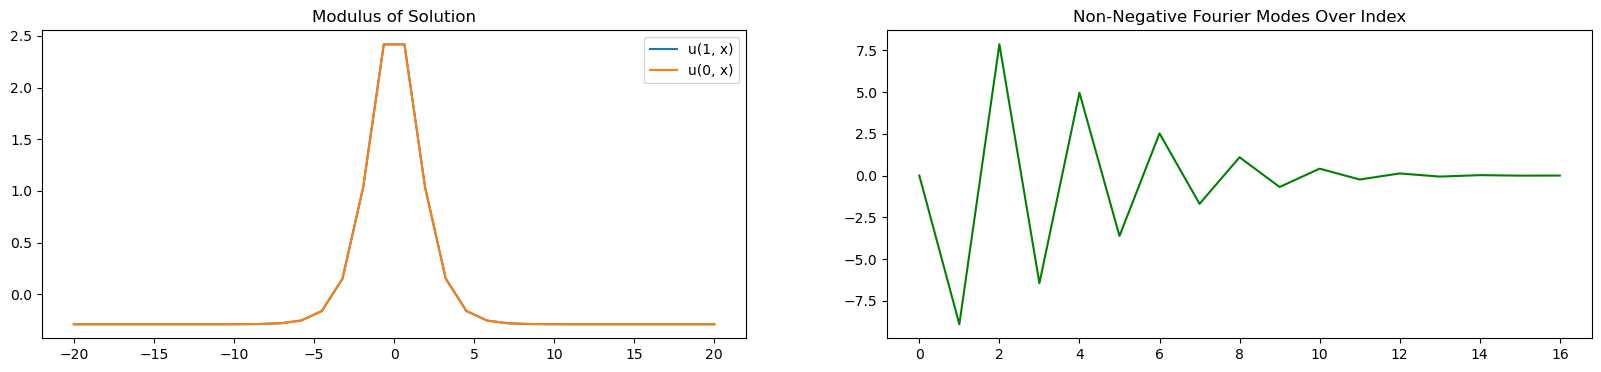

In [107]:
M, L, Tmax = 32, 20, 1
X, y, params = get_data(num_iv=1, M=M, Tmax=0.001, L=L)

xi, u = (y_[0,:] for y_ in y)
xi0 = (X[1][0,:] + 1j * X[0][0,:]) / torch.sqrt(torch.tensor(2))

xi0 = torch.cat((torch.tensor([0]), xi0), axis=-1)

x = torch.linspace(-L, L, M)

u0 = torch.fft.irfft(xi0)

k = torch.arange(M//2 + 1)

fig, ax = plt.subplots(1, 2, figsize=(20, 4))


ax[0].plot(x, u, label=f'u({Tmax}, x)')
ax[0].plot(x, u0, label='u(0, x)')
ax[0].set_title('Modulus of Solution')
ax[1].plot(k, torch.real(xi0), c='green')
ax[1].set_title('Non-Negative Fourier Modes Over Index')
ax[0].legend()
plt.show()

In [108]:
M, h, L, loss = 64, 1e-5, 20, 'fourier'

X_train, y_train, params = get_data(num_iv=100, Tmax=h, M=M, L=L, a=(0.5,1), x0=(0,2))
X_test, y_test, params = get_data(num_iv=100, Tmax=h, M=M, L=L, a=(0.5,1), x0=(0,2))

print(*(torch.mean(torch.linalg.norm(y_train[0][i]-X_train[i])**2) for i in range(2)))

tensor(39774.4648) tensor(35077.4141)


In [109]:
width, depth = 64 , 3
net = SympNet(depth*[width], N=M//2, h=h, activation='relu')
model = SympModel(X_train, y_train, X_test, y_test, net, loss=loss)
 
model.train(iterations=200_000)

tensor(0.0035)
step 	 train loss 	 test loss
100 	 [2.23e-01] 	 [2.31e-01] 	 New best model!
200 	 [1.53e-01] 	 [1.59e-01] 	 New best model!
300 	 [1.10e-01] 	 [1.14e-01] 	 New best model!
400 	 [8.75e-02] 	 [9.28e-02] 	 New best model!
500 	 [8.14e-02] 	 [8.56e-02] 	 New best model!
600 	 [7.52e-02] 	 [8.11e-02] 	 New best model!
700 	 [7.32e-02] 	 [7.76e-02] 	 New best model!
800 	 [6.99e-02] 	 [7.51e-02] 	 New best model!
900 	 [6.81e-02] 	 [7.39e-02] 	 New best model!
1000 	 [6.66e-02] 	 [7.33e-02] 	 New best model!
1100 	 [6.36e-02] 	 [6.89e-02] 	 New best model!
1200 	 [6.35e-02] 	 [6.83e-02] 	 New best model!
1300 	 [6.10e-02] 	 [6.64e-02] 	 New best model!
1400 	 [6.04e-02] 	 [6.51e-02] 	 New best model!
1500 	 [5.88e-02] 	 [6.39e-02] 	 New best model!
1600 	 [5.69e-02] 	 [6.39e-02] 	 
1700 	 [5.50e-02] 	 [6.25e-02] 	 New best model!
1800 	 [5.36e-02] 	 [6.09e-02] 	 New best model!
1900 	 [5.25e-02] 	 [5.99e-02] 	 New best model!
2000 	 [5.25e-02] 	 [5.87e-02] 	 New best model!

KeyboardInterrupt: 

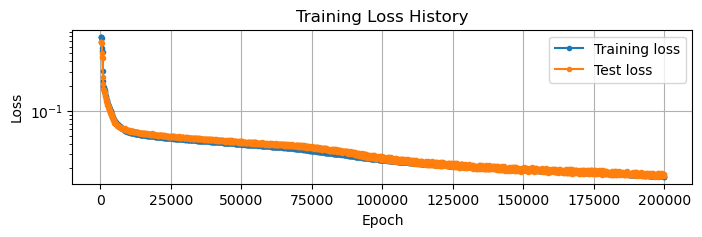

In [ ]:
model.plot_losshistory()

In [84]:
Tmax = 2
iters = int(Tmax / h)
T = h * (iters+1)
t = torch.linspace(0, T, iters+2)[:-1][:,None]
h_tensor = torch.tensor([[h]], dtype=torch.float32)

x = torch.tensor(np.linspace(-L, L, M))[None,:]

X, y, _ = get_data(M=M, num_iv=1, Tmax=Tmax, L=L, num_t=iters, x0=(0,0), a=(1,1))
true_xi, true_u = (y_.detach().numpy() for y_ in y)
true_xi = np.concat((np.zeros_like(true_xi[:,None,0]), true_xi), axis=-1)

true_u_abs = np.abs(true_u)

true_u_r, true_u_i = np.real(true_u), np.imag(true_u)
true_xi_r, true_xi_i, true_xi_abs = np.real(true_xi), np.imag(true_xi), np.abs(true_xi)

p, q = (x.detach().numpy() for x in model.predict(X, h, Tmax=Tmax))

p = np.concat((np.zeros_like(p[:,None,0]), p), axis=-1)
q = np.concat((np.zeros_like(q[:,None,0]), q), axis=-1)

pred_xi = (q + 1j * p) / np.sqrt(2)
pred_u = np.fft.irfft(pred_xi)

pred_u_r, pred_u_i, pred_u_abs = np.real(pred_u), np.imag(pred_u), np.abs(pred_u)
pred_xi_r, pred_xi_i, pred_xi_abs = q / np.sqrt(2), p / np.sqrt(2), np.sqrt((p**2 + q**2) / 2)

X = x[0,:].numpy()
k = np.arange(M//2 + 1)

In [ ]:
'''ANIMATE PREDICTION VS. SOLUTION'''
step = 10*np.max([int(0.01 / h), 1])

# Set up the figure and axis for plotting
fig, ax = plt.subplots(2, 3, figsize=(20, 4))
line1,  = ax[0][0].plot(X, pred_u_r[0,:], '--', c='k')
line2,  = ax[0][0].plot(X, true_u_r[0,:], c='orange', linewidth=6, alpha=0.3)
line3,  = ax[0][1].plot(X, pred_u_i[0,:], '--', c='k')
line4,  = ax[0][1].plot(X, true_u_i[0,:], c='blue', linewidth=6, alpha=0.3)
line5,  = ax[0][2].plot(X, pred_u_abs[0,:], '--', c='k')
line6,  = ax[0][2].plot(X, true_u_abs[0,:], c='green', linewidth=6, alpha=0.3)

line7,  = ax[1][0].plot(k, pred_xi_r[0,:], '--', c='k')
line8,  = ax[1][0].plot(k, true_xi_r[0,:], c='orange', linewidth=6, alpha=0.3)
line9,  = ax[1][1].plot(k, pred_xi_i[0,:], '--', c='k')
line10, = ax[1][1].plot(k, true_xi_i[0,:], c='blue', linewidth=6, alpha=0.3)
line11, = ax[1][2].plot(k, pred_xi_abs[0,:], '--', c='k')
line12, = ax[1][2].plot(k, true_xi_abs[0,:], c='green', linewidth=6, alpha=0.3)

time_text = ax[0][0].text(0, 1.07, f't={0}', transform=ax[0][0].transAxes, fontdict={'fontsize': 20, 'fontweight': 'bold'})


handles = [line2, line4, line6, line1]
labels = ['real', 'imag', 'abs', 'prediction']
fig.legend(handles, labels, loc="upper center", ncol=len(labels), fontsize=10)

lim_r = np.abs(true_u_r).max() * 1.1
lim_i = np.abs(true_u_i).max() * 1.1
lim_abs = true_u_abs.max() * 1.1

ax[0][0].set_ylim(-lim_r, lim_r) 
ax[0][1].set_ylim(-0.05, 0.05)
ax[0][2].set_ylim(0, lim_abs)

lim_r = np.abs(true_xi_r).max() * 1.05
lim_i = np.abs(true_xi_i).max() * 1.05
lim_abs = true_xi_abs.max() * 1.05

ax[1][0].set_ylim(-lim_r, lim_r) 
ax[1][1].set_ylim(-lim_i, lim_i)
ax[1][2].set_ylim(0, lim_abs)

ax[0][0].set_ylabel('u')
ax[1][0].set_ylabel('$\\xi$')

# Define the update function for the animation
def update(frame):
    line1.set_ydata(pred_u_r[step*frame,:])
    line2.set_ydata(true_u_r[step*frame,:])
    line3.set_ydata(pred_u_i[step*frame,:])
    line4.set_ydata(true_u_i[step*frame,:])
    line5.set_ydata(pred_u_abs[step*frame,:])
    line6.set_ydata(true_u_abs[step*frame,:])
    
    line7.set_ydata(pred_xi_r[step*frame,:])
    line8.set_ydata(true_xi_r[step*frame,:])
    line9.set_ydata(pred_xi_i[step*frame,:])
    line10.set_ydata(true_xi_i[step*frame,:])
    line11.set_ydata(pred_xi_abs[step*frame,:])
    line12.set_ydata(true_xi_abs[step*frame,:])
    
    time_text.set_text(f't={step*frame*h:.2f}')  # Update the timer text

    return (line1, line2, line3, line4, time_text)

# Create the animation object
ani = FuncAnimation(fig, update, frames=pred_u_r.shape[0] // step, interval=50, blit=True)
# Display the animation inline in the notebook

plt.close(fig)

HTML(ani.to_jshtml())
